In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv
/kaggle/input/customer-segmentation-in-python/__results__.html
/kaggle/input/customer-segmentation-in-python/__notebook__.ipynb
/kaggle/input/customer-segmentation-in-python/__output__.json
/kaggle/input/customer-segmentation-in-python/custom.css
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_3.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_5.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___10_1.png
/kaggle/input/customer-segmentation-in-python/__results___files/__results___8_1.png


Dataset Preview:
   InvoiceNo  StockCode                        Description  Quantity  \
0   541431.0    23166.0     MEDIUM CERAMIC TOP STORAGE JAR     74215   
1        NaN    23166.0     MEDIUM CERAMIC TOP STORAGE JAR    -74215   
2   537626.0    85116.0    BLACK CANDELABRA T-LIGHT HOLDER        12   
3   537626.0    22375.0  AIRLINE BAG VINTAGE JET SET BROWN         4   
4   537626.0    71477.0  COLOUR GLASS. STAR T-LIGHT HOLDER        12   

        InvoiceDate  UnitPrice  CustomerID         Country      Recency  \
0  01/18/2011 10:01       1.04     12346.0  United Kingdom  5137.571528   
1  01/18/2011 10:17       1.04     12346.0  United Kingdom  5137.571528   
2  12/07/2010 14:57       2.10     12347.0         Iceland  4814.338889   
3  12/07/2010 14:57       4.25     12347.0         Iceland  4814.338889   
4  12/07/2010 14:57       3.25     12347.0         Iceland  4814.338889   

   Frequency  MonetaryValue       AOV  
0        2.0           2.08  1.040000  
1        2.0       

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Running time for k = 3: 0.1369 seconds


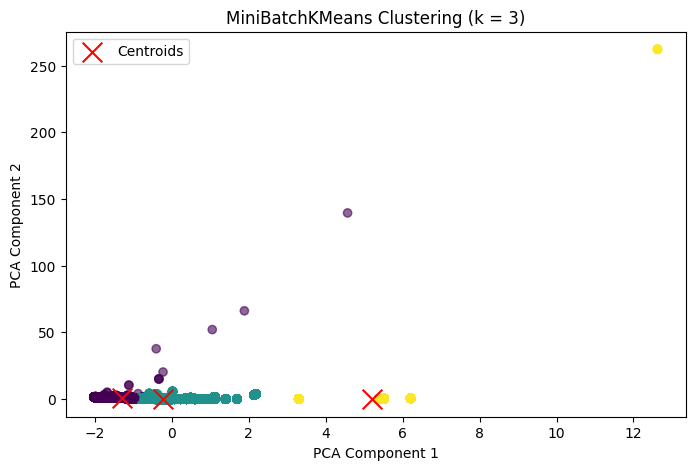

Running time for k = 4: 0.0859 seconds


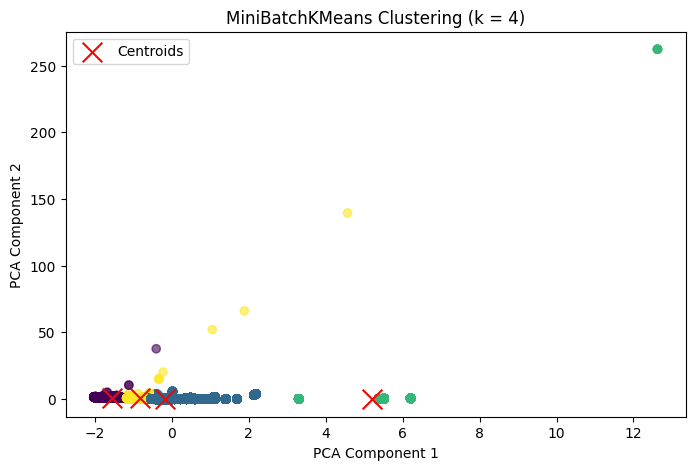

Running time for k = 5: 0.0878 seconds


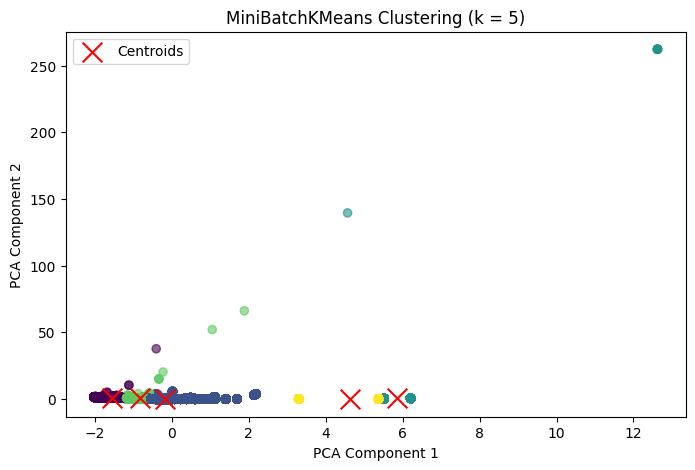

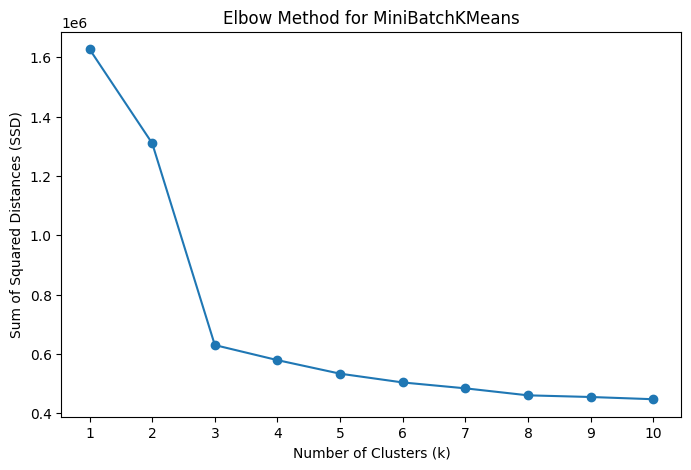

For k = 3: Silhouette Score = 0.75, Davies-Bouldin Index = 0.44
For k = 4: Silhouette Score = 0.63, Davies-Bouldin Index = 0.51
For k = 5: Silhouette Score = 0.63, Davies-Bouldin Index = 0.64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# -----------------------------------------------------------
# Step 1: Load the Dataset
# -----------------------------------------------------------
data = pd.read_csv('/kaggle/input/dataset-ds/DS for Lab 4 Assignment.csv')
print("Dataset Preview:")
print(data.head())
print("\nDataset Columns:")
print(data.columns)

# -----------------------------------------------------------
# Step 2: Data Preprocessing & Feature Selection
# -----------------------------------------------------------
# We use key metrics for customer segmentation: Recency, Frequency, MonetaryValue, and AOV.
features = data[['Recency', 'Frequency', 'MonetaryValue', 'AOV']]
features = features.dropna()               # Drop rows with missing values
features = features.fillna(features.mean())  # Fill remaining missing values

# -----------------------------------------------------------
# Step 3: Normalize the Features
# -----------------------------------------------------------
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

# -----------------------------------------------------------
# Step 4: Dimensionality Reduction for Visualization
# -----------------------------------------------------------
# Use PCA to reduce dimensions to 2 components for visualization.
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# -----------------------------------------------------------
# Step 5: Apply MiniBatchKMeans Clustering with Timing
# -----------------------------------------------------------
# Test clustering with k = 3, 4, and 5.
k_values = [3, 4, 5]

for k in k_values:
    start_time = time.perf_counter()
    
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k, 
        batch_size=5000,    # Increased batch size
        n_init=1,           # Fewer initializations
        max_iter=100,       # Limit max iterations
        random_state=42
    )
    labels = minibatch_kmeans.fit_predict(normalized_data)
    
    end_time = time.perf_counter()
    running_time = end_time - start_time
    print(f"Running time for k = {k}: {running_time:.4f} seconds")
    
    # Visualize clusters using the PCA-reduced data
    plt.figure(figsize=(8, 5))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Transform cluster centers into PCA space for plotting
    centers = minibatch_kmeans.cluster_centers_
    centers_pca = pca.transform(centers)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
                s=200, c='red', marker='x', label='Centroids')
    
    plt.title(f'MiniBatchKMeans Clustering (k = {k})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

# -----------------------------------------------------------
# Step 6: Determine the Optimal Number of Clusters (Elbow Method)
# -----------------------------------------------------------
ssd = []  # Sum of Squared Distances for each k
K_range = range(1, 11)
for k in K_range:
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=5000,
        n_init=1,
        max_iter=100,
        random_state=42
    )
    minibatch_kmeans.fit(normalized_data)
    ssd.append(minibatch_kmeans.inertia_)  # Inertia is the sum of squared distances

plt.figure(figsize=(8, 5))
plt.plot(K_range, ssd, '-o')
plt.title('Elbow Method for MiniBatchKMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(K_range)
plt.show()

# -----------------------------------------------------------
# Step 7: Evaluate Clustering Performance
# -----------------------------------------------------------
for k in k_values:
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=5000,
        n_init=1,
        max_iter=100,
        random_state=42
    )
    labels = minibatch_kmeans.fit_predict(normalized_data)
    sil_score = silhouette_score(normalized_data, labels)
    db_index = davies_bouldin_score(normalized_data, labels)
    print(f'For k = {k}: Silhouette Score = {sil_score:.2f}, Davies-Bouldin Index = {db_index:.2f}')

# -----------------------------------------------------------
# Step 8: Business Interpretation (Report Section)
# -----------------------------------------------------------
# In your analysis/report, you would examine each cluster to understand:
# - Which cluster represents high-value customers (e.g., low Recency, high Frequency and MonetaryValue, high AOV)
# - Which cluster might indicate occasional buyers or budget shoppers.
# These insights help in designing targeted marketing strategies.
